<a href="https://colab.research.google.com/github/squashai/notebooks/blob/main/baseline_court_positions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline estimation of player positions on the squash court

This notebook trains a convolutional neural network inspired by [Simple Baselines for Human Pose Estimation and Tracking
](https://paperswithcode.com/paper/simple-baselines-for-human-pose-estimation) on the [SquashAI player position dataset](https://github.com/squashai/datasets).

[![SQUASHAI](https://img.shields.io/badge/SQUASH-AI-black)](https://squashai.github.io)
[![View source on Github](https://img.shields.io/badge/-View%20source%20on%20Github-blue?logo=github&labelColor=black)](https://github.com/squashai/notebooks/blob/main/baseline_court_positions.ipynb)


# Initialization

## Dataset Retrievial

In [ ]:
%cd /content/
!curl -L --output datasets+img.tar.gz https://github.com/squashai/datasets/releases/download/0.0.6/datasets+img.tar.gz
!tar zxf datasets+img.tar.gz

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   647  100   647    0     0   5134      0 --:--:-- --:--:-- --:--:--  5134
100  228M  100  228M    0     0  63.7M      0  0:00:03  0:00:03 --:--:-- 71.7M


In [ ]:
%cd /content/datasets+img/

/content/datasets+img


## Imports and Variables

In [ ]:
# imports for data and model handling
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import cv2
import shutil
from random import random
from math import floor, log10
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import (
    Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, MaxPool2D,
    Flatten, Dense, Dropout
)
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.utils import plot_model

In [ ]:
# downloaded dataset
DATASET_DIR = '.'
DATASET_IMAGES_DIR = 'media/images'

# image size for model training and testing
#   height/width ratio should be same as images': 720/1280)
MODEL_INPUT_SIZE = (108, 192)

# court size, used for adjusting player coordinates and for
# creating model heatmaps
#   height/width ratio should be same as court's: 975/640
COURT_SIZE = (195, 128)

# gaussian Sigma for model heatmaps
HEATMAP_SIGMA = 10

# zoom factor
MAX_ZOOM_FACTOR = 1.3

# model variables
NUM_EPOCHS = 100
BATCH_SIZE = 128
BEST_MODEL_FILE = 'best_bl-positions_model.hdf5'
LAST_MODEL_FILE = 'last_bl-positions_model.hdf5'

# path to final store for models (should be persistent)
PERSISTENT_MODELS_DIR = '/content/drive/My Drive/colab-data'

In [ ]:
# dataset data
images = []
positions = []

# background image for positions and heatmaps
ground = None

# train, test and evaluation data
model_images = []
model_positions = []
model_heatmaps = []

## Data Preparation

### Helper Functions

In [ ]:
def adjust_position(position, output_size=COURT_SIZE):
    new_h, new_w = output_size
    position = position * [100, -100]
    position = position + [640 / 2, 975 / 2]
    position = position * [new_w / 640, new_h / 975]
    return position

#### Tests

In [ ]:
tl = np.array([-3.2, 4.875])
tr = np.array([3.2, 4.875])
bl = np.array([-3.2, -4.875])
br = np.array([3.2, -4.875])
print('tl: {} => {}'.format(tl, adjust_position(tl)))
print('tr: {} => {}'.format(tr, adjust_position(tr)))
print('bl: {} => {}'.format(bl, adjust_position(bl)))
print('br: {} => {}'.format(br, adjust_position(br)))

tl: [-3.2    4.875] => [0. 0.]
tr: [3.2   4.875] => [128.   0.]
bl: [-3.2   -4.875] => [  0. 195.]
br: [ 3.2   -4.875] => [128. 195.]


### Data Extraction

In [ ]:
images.clear()
positions.clear()

for data_file in os.listdir(DATASET_DIR)[:]:
    if not data_file.startswith('.') and data_file.endswith('.json'):
        with open(data_file) as fd:
            data = json.load(fd)
        tlen = 1
        for label in data['labels']:
            if label['time'] > 0:
                tlen = max(tlen, floor(log10(label['time'] * 1000)) + 1)

        for label in data['labels']:
            time = label['time'] * 1000
            image_file = os.path.join(DATASET_IMAGES_DIR,
                                      '%s-%0*d.jpg' % (data_file[:-5],
                                                       tlen, time))
            #image = np.array(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))
            image = np.array(mpimg.imread(image_file))
            #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            images.append(image)

            players = []
            for id in ['1', '2']:
                if label['players'][id]['visible'] is True:
                    players.append(adjust_position(np.array([
                        label['players'][id]['x'],
                        label['players'][id]['y']
                    ], dtype=np.float16)))
                    players.sort(key=lambda p: p[0] * p[0] + p[1] * p[1])
                else:
                    players.append(np.array([float('NaN'), float('NaN')],
                                            dtype=np.float16))
            positions.append(players)
            

#### Inspection

In [ ]:
print('Shape of images: {}'.format(np.shape(images)))
print('Shape of positions: {}'.format(np.shape(positions)))

Shape of images: (1253, 720, 1280, 3)
Shape of positions: (1253, 2, 2)


### Helper Functions

#### Plotting Functions

In [ ]:
!wget -O ground.png https://raw.githubusercontent.com/squashai/squashai/master/src/assets/ground.png

--2020-11-14 08:36:52--  https://raw.githubusercontent.com/squashai/squashai/master/src/assets/ground.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209494 (205K) [image/png]
Saving to: ‘ground.png’

ground.png          100%[===================>] 204.58K  --.-KB/s    in 0.008s  

2020-11-14 08:36:52 (25.1 MB/s) - ‘ground.png’ saved [209494/209494]



In [ ]:
ground = np.array(mpimg.imread('ground.png'))[:, :, :3]
ground = cv2.resize(ground, (COURT_SIZE[1], COURT_SIZE[0]),
                    interpolation=cv2.INTER_AREA)


In [ ]:
def plot_image(image=None, players=None, heatmap=None):

    fig = plt.figure(figsize=(20, 7))
    if players is None and heatmap is None:
        pic = fig.subplots()
    else:
        gs = fig.add_gridspec(1, 3)
        pic = fig.add_subplot(gs[0, :-1])
        graph = fig.add_subplot(gs[0, -1])
        graph.imshow(ground)

    if image is not None:
        if hasattr(image, 'dtype') and image.dtype == np.float16:
            pic.imshow(np.array(image, dtype=np.float32))
        else:
            pic.imshow(image)

    if players is not None:
        for player in players:
            if not np.any(np.isnan(player)):
                graph.scatter(*player,
                              s=50, marker='.', color='red')

    if heatmap is not None:
        h, w = np.shape(heatmap)[:2]
        n = np.shape(heatmap)[-1]

        rgba = np.zeros((h, w, 4))
        rgba[:, :, 1] = heatmap[:h, :w, 0]
        rgba[:, :, 3] = heatmap[:h, :w, 0]
        if np.shape(heatmap)[2] > 1:
            rgba[:, :, 2] = heatmap[:h, :w, 1]
            rgba[:, :, 3] += heatmap[:h, :w, 1]

        max_val = rgba.max()
        if max_val > 0:
            rgba *= (1 / max_val)
        rgba[rgba < 0] = 0

        graph.imshow(rgba)

    plt.show()

##### Tests

In [ ]:
n = 900

image = images[n]
players = positions[n]

plot_image(image)
plot_image(image, players)

#### Heatmap Functions

In [ ]:
def position_to_layer(position, output_size, sigma):
    if np.any(np.isnan(position)):
        return np.zeros(output_size, dtype=np.float16)
    else:
        x0, y0 = position
        h, w = output_size
        if np.any(np.isnan(position)):
            return np.zeros(output_size, dtype=np.float16)
        x = np.arange(0, w, 1, dtype=np.float16)
        y = np.arange(0, h, 1, dtype=np.float16)[:, np.newaxis]
        return np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

def positions_to_heatmap(positions, output_size, sigma):
    h, w = output_size
    heatmap = np.zeros((h, w, len(positions)), dtype=np.float16)
    for idx in range(len(positions)):
        heatmap[:, :, idx] = position_to_layer(positions[idx],
                                               output_size, sigma)
    return heatmap

In [ ]:
def layer_to_position(hm_layer, num_points=4, threshold=0.2):
    ## pick the largest num_points
    ind = hm_layer.argsort(axis=None)[-num_points:]
    topind = np.unravel_index(ind, np.shape(hm_layer))
    index = np.unravel_index(hm_layer.argmax(), np.shape(hm_layer))
    y, x, hsum = 0, 0, 0
    for ind in zip(topind[0],topind[1]):
        h  = hm_layer[ind[0],ind[1]]
        hsum += h
        y   += ind[0]*h
        x   += ind[1]*h

    if hsum / num_points <= threshold:
        y, x = float('NaN'), float('NaN')
    else:
        y /= hsum
        x /= hsum
 
    return [x, y]

def heatmap_to_positions(heatmap, num_points=4, threshold=0.2):
    positions = []
    for l in range(np.shape(heatmap)[-1]):
        positions.append(layer_to_position(heatmap[:, :, l],
                                           num_points, threshold))

    return positions

##### Tests

In [ ]:
n = 90

image = images[n]
players = positions[n]
heatmap = positions_to_heatmap(players, COURT_SIZE, 10)

plot_image(image, players)
plot_image(image, heatmap=heatmap, players=players)
plot_image(image, players=heatmap_to_positions(heatmap))
for idx in range(np.shape(heatmap)[-1]):
    plot_image(heatmap[:, :, idx])

#### Scaling Functions

In [ ]:
def scale_image(image, output_size):
    h, w = image.shape[:2]
    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)
    new_image = cv2.resize(image, (new_w, new_h))
    return new_image

scale = scale_image

##### Tests

In [ ]:
n = 20
downscale = (72, 128)
upscale = (1080, 1920)

image = images[n]
players = positions[n]
small_image = scale(image, downscale)
heatmap = positions_to_heatmap(players, COURT_SIZE, 10)

plot_image(image, players)
plot_image(small_image, heatmap=heatmap)
plot_image(small_image, players, heatmap)

#### Cropping Functions

In [ ]:
def crop_image(image, output_size):
    h, w = image.shape[:2]
    if isinstance(output_size, int):
        new_h, new_w = (output_size, output_size)
    else:
        new_h, new_w = output_size
    top = int((h - new_h) / 2)
    left = int((w - new_w) / 2)

    image = image[top : top + new_h,
                  left : left + new_w]
    return image

crop = crop_image


##### Tests

In [ ]:
n = 20
downsize = (500, 500)

image = images[n]
players = positions[n]
small_image = crop(image, downsize)
heatmap = positions_to_heatmap(players, COURT_SIZE, 15)

plot_image(image, players)
plot_image(small_image, heatmap=heatmap)
plot_image(small_image, players, heatmap)

#### Zoom Functions

In [ ]:
def zoom_image(image, factor):
    new_size = np.array(image.shape[:2]) * factor
    new_image = scale_image(image, new_size)
    return crop_image(new_image, np.shape(image)[:2])


zoom = zoom_image

##### Tests

In [ ]:
n = 11
factor = 1.6

image = images[n]
players = positions[n]
zoomed_image = zoom(image, factor)
heatmap = positions_to_heatmap(players, COURT_SIZE, 20)

plot_image(image, players)
plot_image(zoomed_image, players, heatmap)

#### Flipping Functions

In [ ]:
def flip_image(image):
    if hasattr(image, 'dtype') and image.dtype == np.float16:
        image = cv2.flip(np.array(image, dtype=np.float32), 1)
        return np.array(image, dtype=np.float16)
    else:
        return cv2.flip(image, 1)

def flip_positions(positions, input_size):
    center = input_size[1] / 2
    new_pos = np.array(positions)
    new_pos[:, 0] = 2 * center - new_pos[:, 0]
    new_pos = list(new_pos)
    new_pos.sort(key=lambda p: p[0] * p[0] + p[1] * p[1])
    return np.array(new_pos)

def flip(image, positions=None, input_size=COURT_SIZE):
    new_img = flip_image(image)
    if positions is not None:
        new_pos = flip_positions(positions, input_size)
        return new_img, new_pos
    return new_img

##### Tests

In [ ]:
n = 40

image = images[n]
players = positions[n]
heatmap = positions_to_heatmap(players, COURT_SIZE, 20)
flipped_image, flipped_players = flip(image, players)
flipped_heatmap = positions_to_heatmap(flipped_players,
                                       COURT_SIZE, 20)

plot_image(image, players, heatmap)
plot_image(flipped_image, flipped_players, flipped_heatmap)

#### Persistance Functions

In [ ]:
def persist(filename):
    shutil.copy(filename, os.path.join(PERSISTENT_MODELS_DIR, filename))

def restore(filename):
    shutil.copy(os.path.join(PERSISTENT_MODELS_DIR, filename), filename)

def unpersist(filename):
    os.remove(os.path.join(PERSISTENT_MODELS_DIR, filename))

##### Tests

In [ ]:
!echo Hi > foobar
persist('foobar')
!rm foobar
!stat foobar
restore('foobar')
!cat foobar
!rm foobar
unpersist('foobar')
try:
    restore('foobar')
except:
    print('`restore()` correctly failed')

stat: cannot stat 'foobar': No such file or directory
Hi
`restore()` correctly failed


### Data Augmentation

In [ ]:
model_images.clear()
model_positions.clear()
model_heatmaps.clear()

def store(image, players, heatmap):
    model_images.append(image)
    model_positions.append(players)
    model_heatmaps.append(heatmap)
    return image, players, heatmap

def downscale_and_store(image, players):
    scaled_image = scale(image, MODEL_INPUT_SIZE)
    heatmap = positions_to_heatmap(players, COURT_SIZE, HEATMAP_SIGMA)
    return store(scaled_image, players, heatmap)[:2]

def flip_and_store(image, players):
    flipped_image, flipped_players = flip(image, players)
    flipped_heatmap = positions_to_heatmap(flipped_players,
                                           COURT_SIZE, HEATMAP_SIGMA)
    return store(flipped_image, flipped_players, flipped_heatmap)[:2]


for idx in range(len(images[:])):
    # downscale and store
    #downscale_and_store(images[idx], boxes[idx])

    # downscale original and store, then flip and store again
    flip_and_store(*downscale_and_store(images[idx], positions[idx]))
 
    # zoom original...
    zoomed_image = zoom(images[idx],
                        random() * (MAX_ZOOM_FACTOR - 1) + 1)

    # ... then downscale zoomed and store, then flip zoomed downscaled
    # and store
    flip_and_store(*downscale_and_store(zoomed_image, positions[idx]))
 

#### Data Inspection

In [ ]:
print('Shape of model images: {}'.format(np.shape(model_images)))
print('Shape of model positions: {}'.format(np.shape(model_positions)))
print('Shape of model heatmaps: {}'.format(np.shape(model_heatmaps)))

Shape of model images: (5012, 108, 192, 3)
Shape of model positions: (5012, 2, 2)
Shape of model heatmaps: (5012, 195, 128, 2)


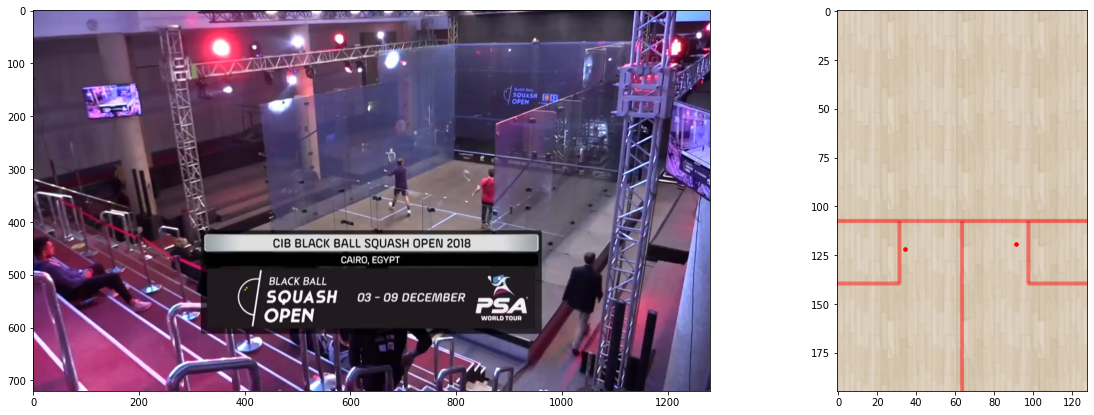

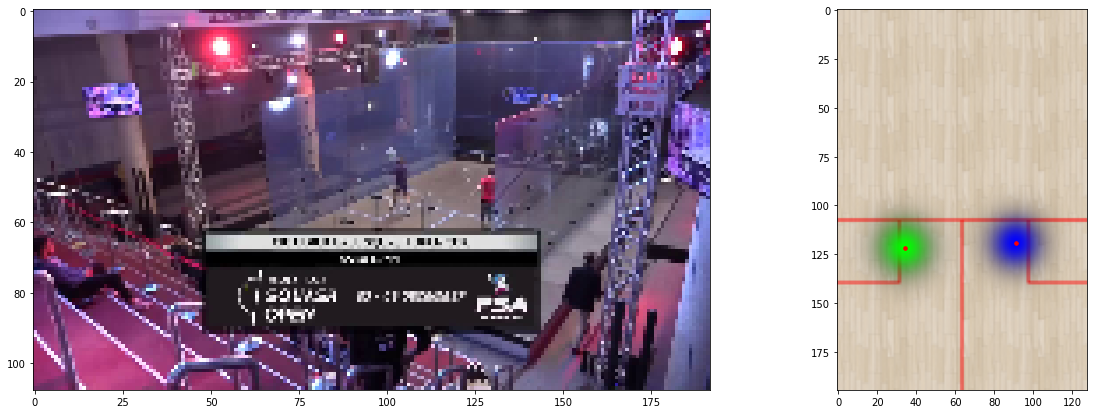

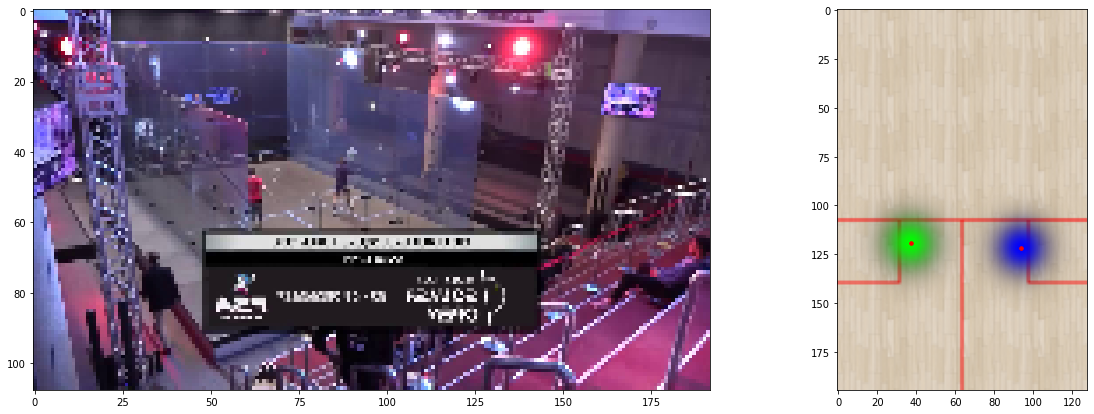

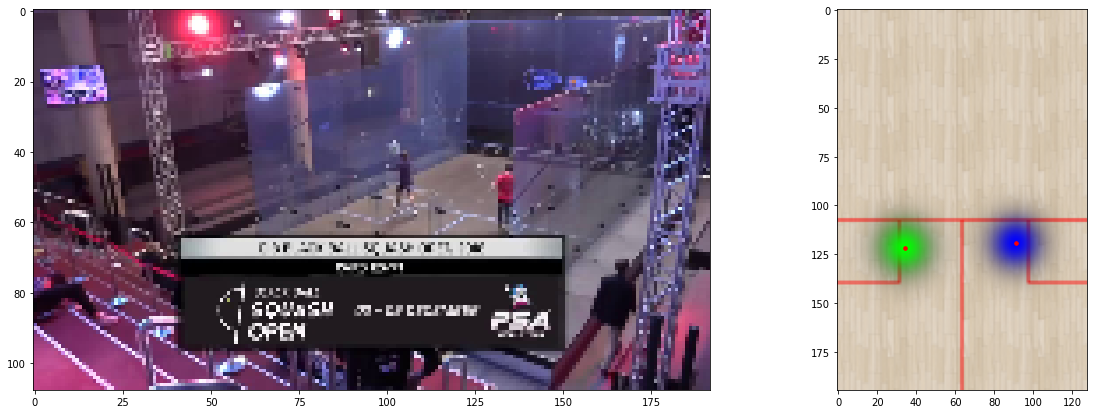

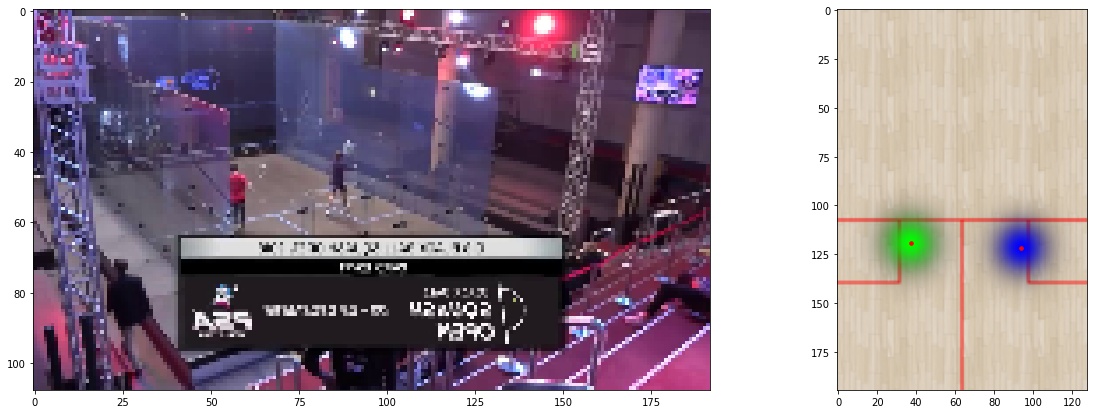

In [ ]:
n = 5

plot_image(images[n], positions[n])
for idx in range(n * 4, n * 4 + 4):
    plot_image(model_images[idx], model_positions[idx], model_heatmaps[idx])


# Model Preparation

## Model Creation

94773248/94765736 [==============================] - 1s 0us/step


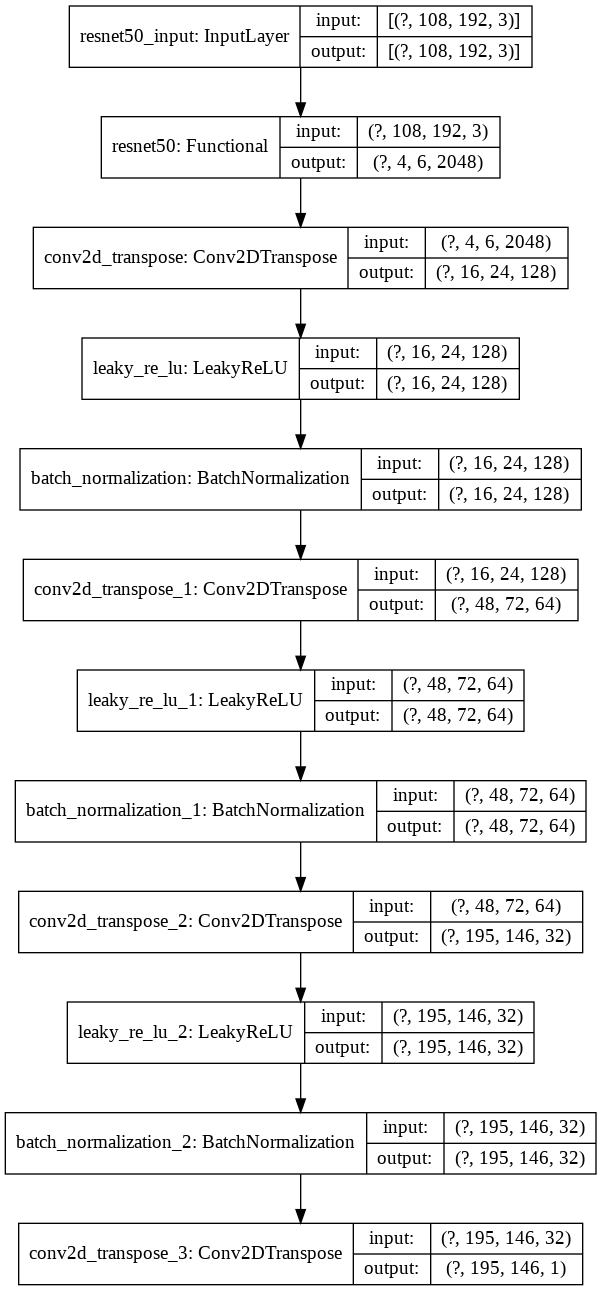

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, input_shape=np.shape(model_images)[1:]))

model.add(Conv2DTranspose(128, [4, 4], strides=[4, 4], 
                          padding='same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Conv2DTranspose(64, [4, 4], strides=[3, 3],
                          padding='same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Conv2DTranspose(32, [4, 4], strides=[4, 2],
          output_padding=(3,0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Conv2DTranspose(1, [1, 1], strides=[1, 1],
          padding='same', activation=None))

plot_model(model, show_shapes=True)

### Output Adjustment

In [ ]:
print('Model output shape: {}'.format(model.output_shape))
print('Heatmaps shape: {}'.format(np.shape(model_heatmaps)))

Model output shape: (None, 195, 146, 1)
Heatmaps shape: (5012, 195, 128, 2)


In [ ]:
# input and output oughta be numpy arrays (or tensors)
train_input = np.array(model_images)
train_output = np.array(model_heatmaps)
train_output = np.maximum(train_output[:, :, :, 0], train_output[:, :, :, 1])
train_output = np.reshape(train_output, (-1, 195, 128, 1))
train_output = np.pad(train_output, ((0,0), (0,0), (0,18), (0,0)))

### Inspection

In [ ]:
print('Model input shape: {}'.format(model.input_shape))
print('Train input shape: {}'.format(np.shape(train_input)))
print('Model output shape: {}'.format(model.output_shape))
print('Train output shape: {}'.format(np.shape(train_output)))

Model input shape: (None, 108, 192, 3)
Train input shape: (5012, 108, 192, 3)
Model output shape: (None, 195, 146, 1)
Train output shape: (5012, 195, 146, 1)


In [ ]:
n = 450


plot_image(model_images[n], heatmap=model_heatmaps[n])
plot_image(train_input[n], heatmap=train_output[n, :, :-18, :])

## Model Training

In [ ]:
# define necessary callbacks
checkpointer = ModelCheckpoint(filepath=BEST_MODEL_FILE, monitor='val_mae',
                               verbose=1, save_best_only=True, mode='min')

# compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error', metrics=['mae', 'acc'])

# Train the model
history = model.fit(train_input, train_output,
                    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split=0.05, callbacks=[checkpointer])

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.1611 - mae: 0.1520 - acc: 0.5466
Epoch 00001: val_mae improved from inf to 365.40631, saving model to best_bl-positions_model.hdf5
38/38 [==============================] - 28s 748ms/step - loss: 0.1611 - mae: 0.1520 - acc: 0.5466 - val_loss: 727842.4375 - val_mae: 365.4063 - val_acc: 0.5089
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.0191 - mae: 0.0677 - acc: 0.5568
Epoch 00002: val_mae improved from 365.40631 to 5.31708, saving model to best_bl-positions_model.hdf5
38/38 [==============================] - 27s 708ms/step - loss: 0.0191 - mae: 0.0677 - acc: 0.5568 - val_loss: 144.0505 - val_mae: 5.3171 - val_acc: 0.5107
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.0185 - mae: 0.0665 - acc: 0.5569
Epoch 00003: val_mae improved from 5.31708 to 0.07655, saving model to best_bl-positions_model.hdf5
38/38 [==============================] - 28s 727ms/step - loss: 0.0185 

#### Model Persist

In [ ]:
model.save(LAST_MODEL_FILE)
persist(BEST_MODEL_FILE)
persist(LAST_MODEL_FILE)

### Learning Curves

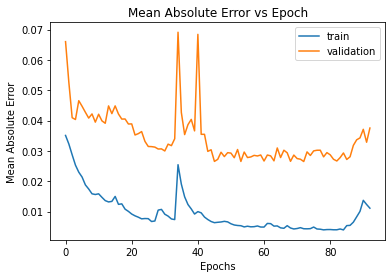

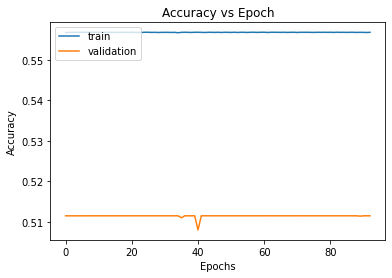

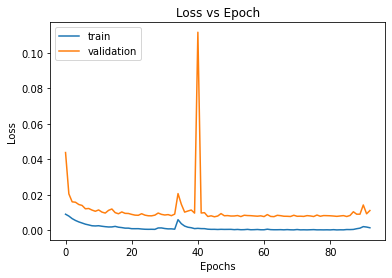

In [ ]:
start = 7

# summarize history for mean_absolute_error
try:
    plt.plot(history.history['mae'][start:])
    plt.plot(history.history['val_mae'][start:])
    plt.title('Mean Absolute Error vs Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['acc'][start:])
    plt.plot(history.history['val_acc'][start:])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'][start:])
    plt.plot(history.history['val_loss'][start:])
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
except:
    print("One of the metrics used for plotting graphs is missing! See 'model.compile()'s `metrics` argument.")

### Predictions on Training Data

In [ ]:
test_preds = model.predict(train_input)

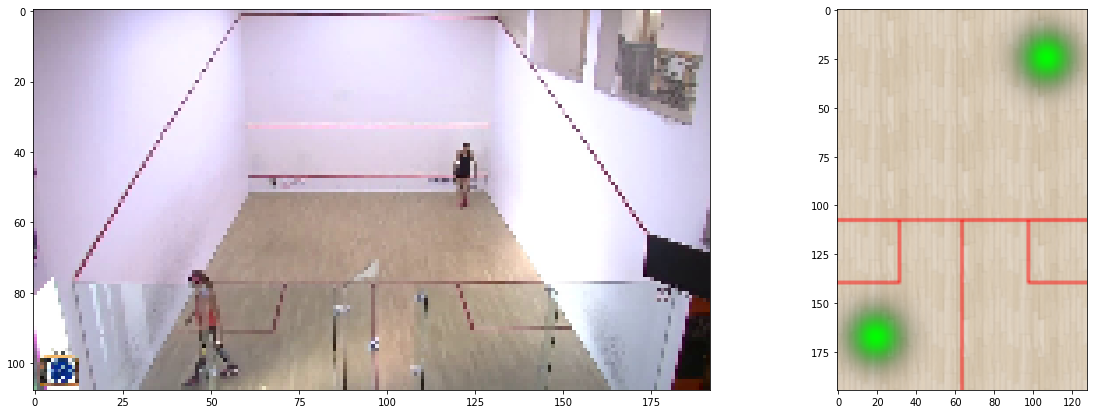

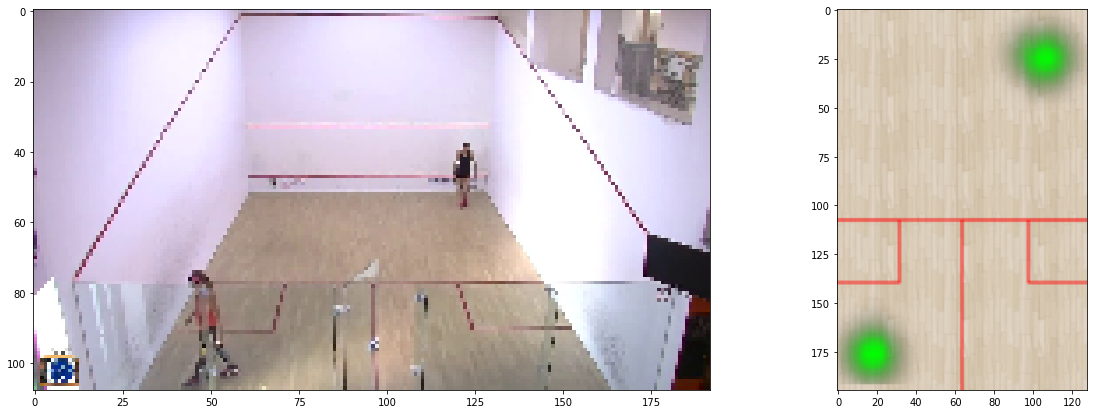

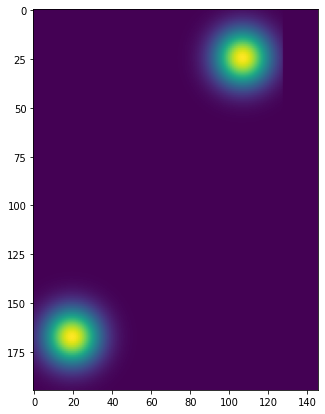

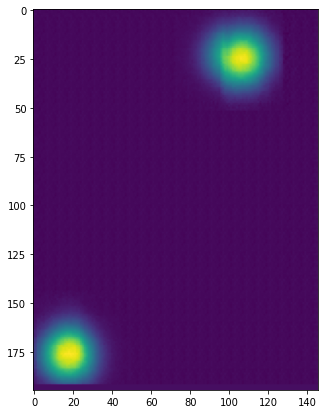

In [ ]:
n = int(random() * len(train_input))

plot_image(train_input[n], heatmap=train_output[n, :, :-18, :])
plot_image(train_input[n], heatmap=test_preds[n, :, :-18, :])
plot_image(train_output[n, :, :, 0])
plot_image(test_preds[n, :, :, 0])

## Model Restore

In [ ]:
MODEL_FILE = BEST_MODEL_FILE
#MODEL_FILE = LAST_MODEL_FILE

restore(MODEL_FILE)
model = load_model(MODEL_FILE)

## Predictions on New Data

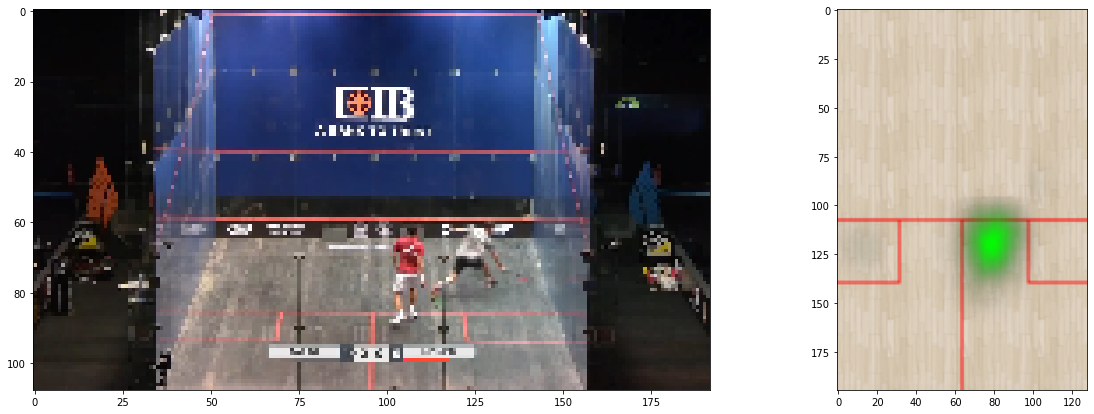

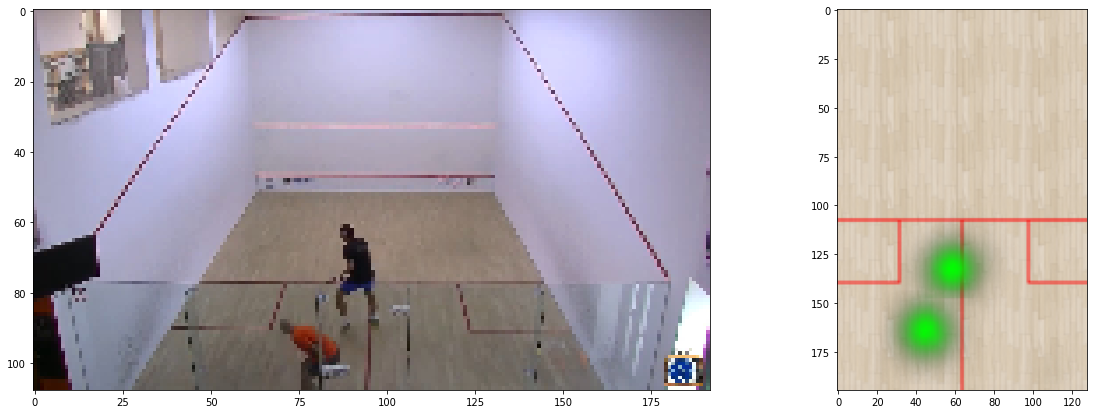

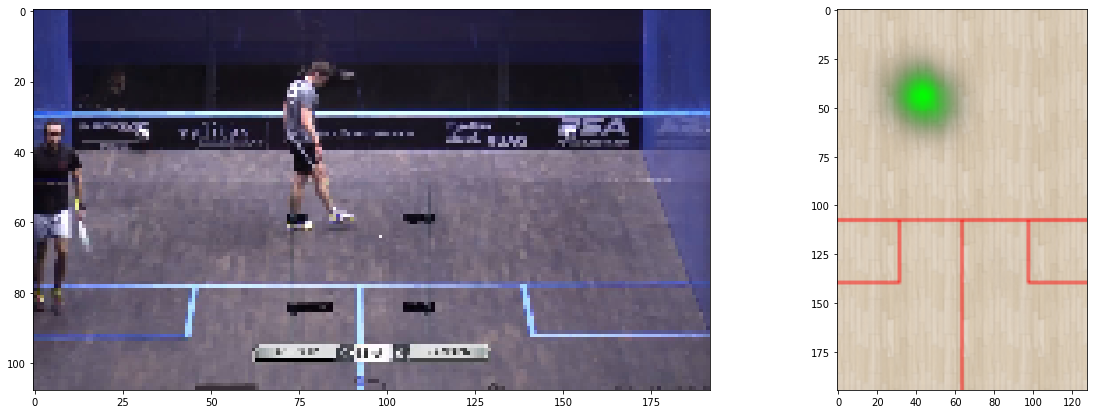

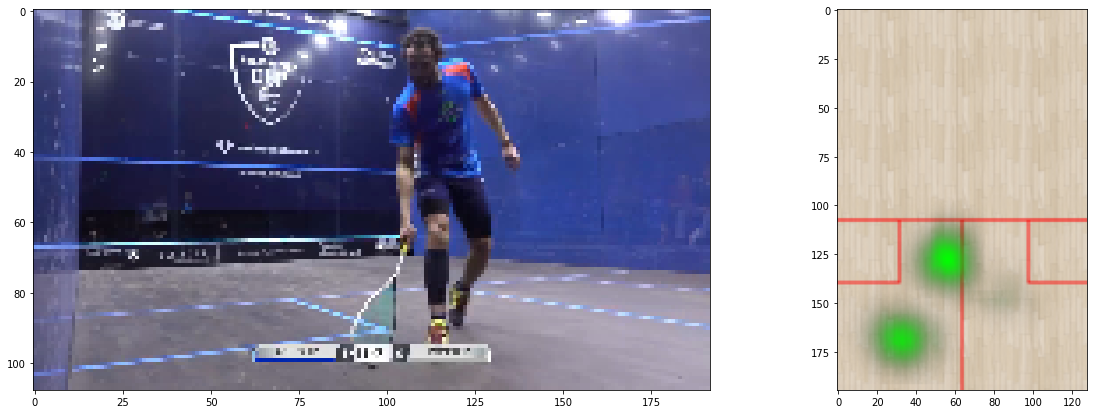

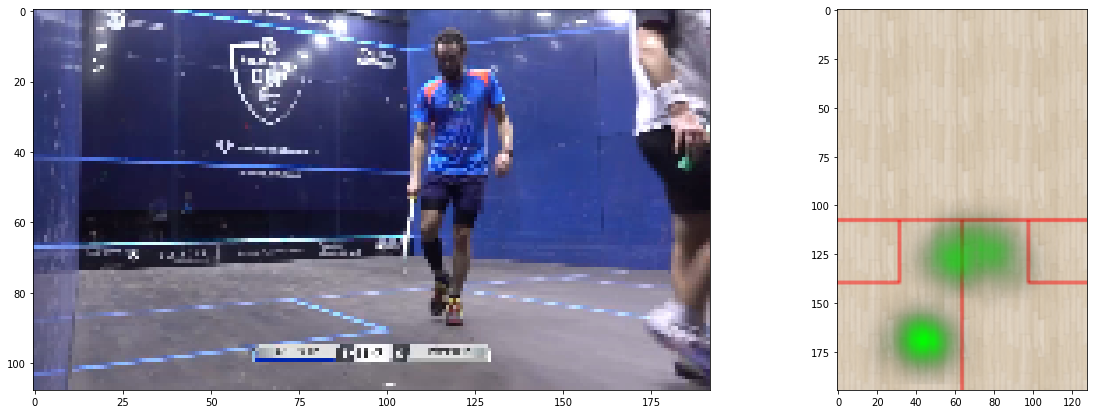

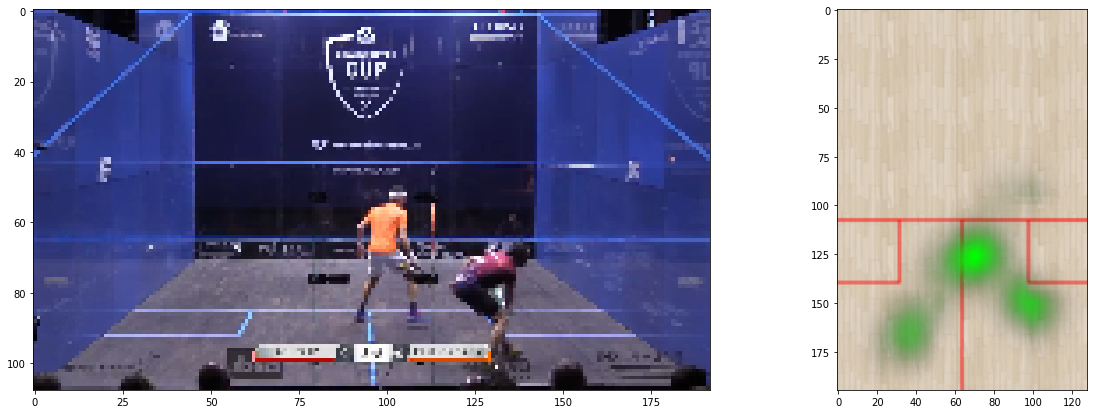

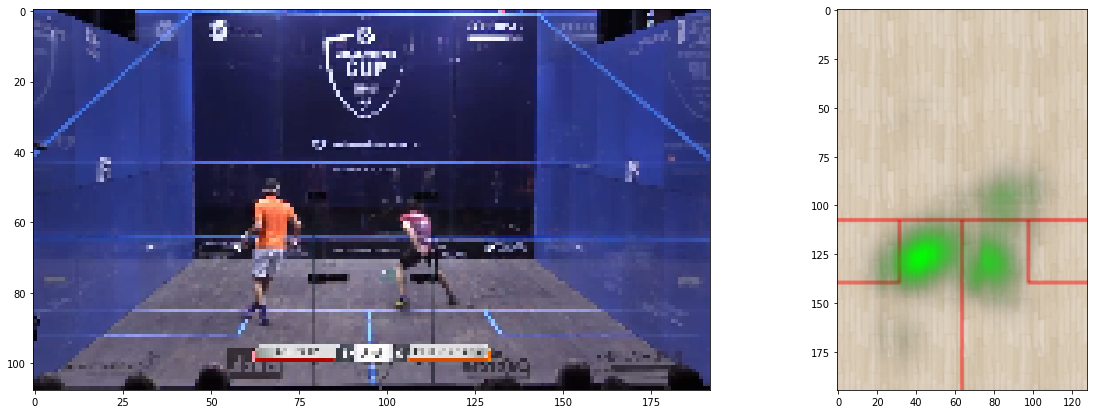

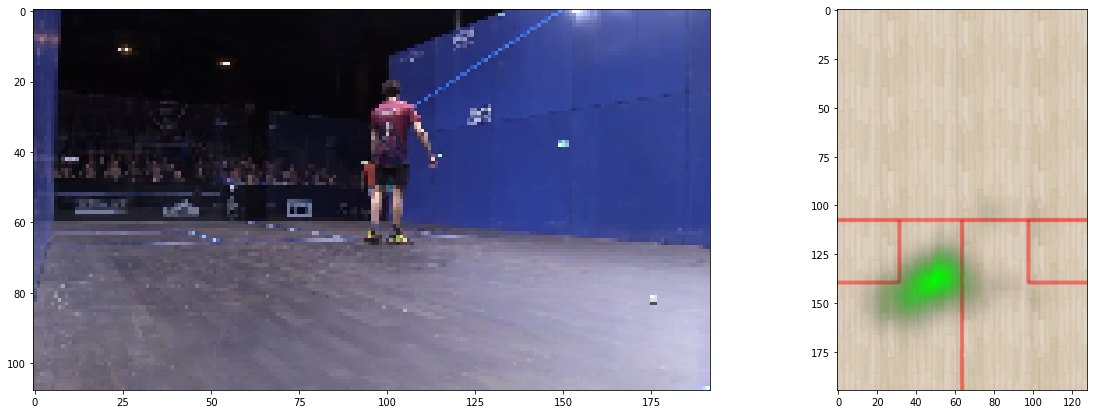

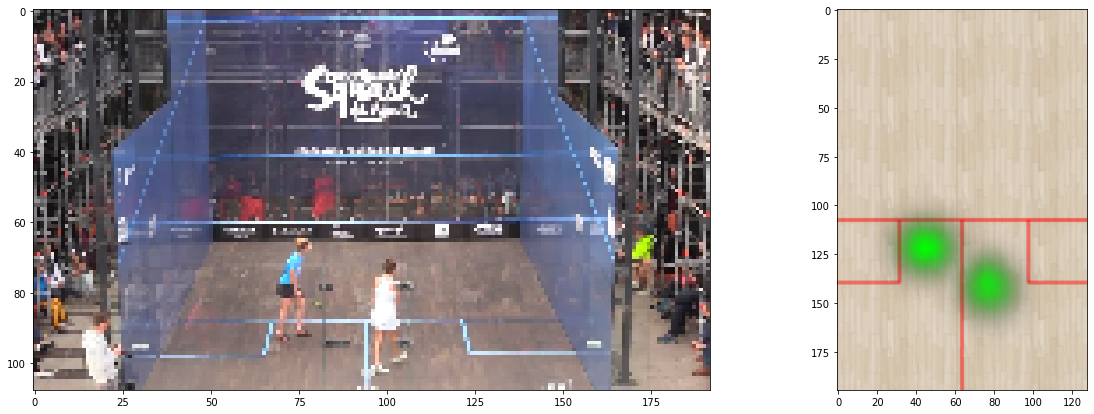

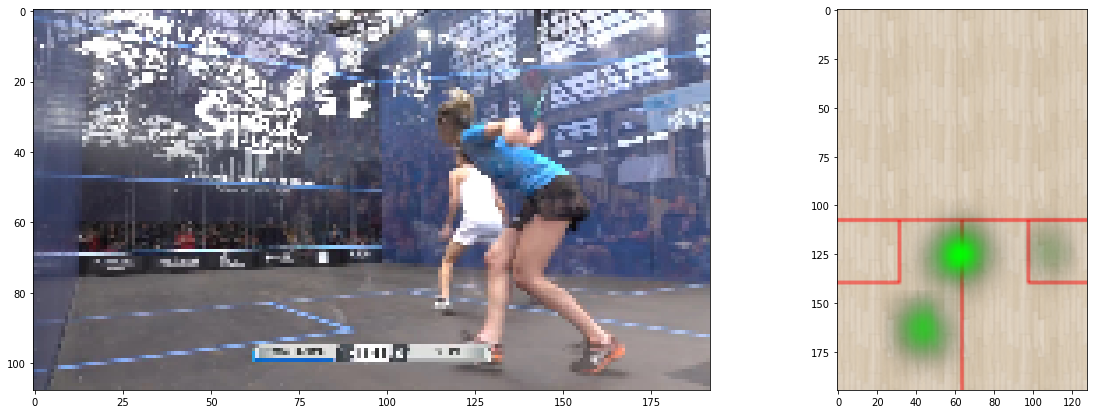

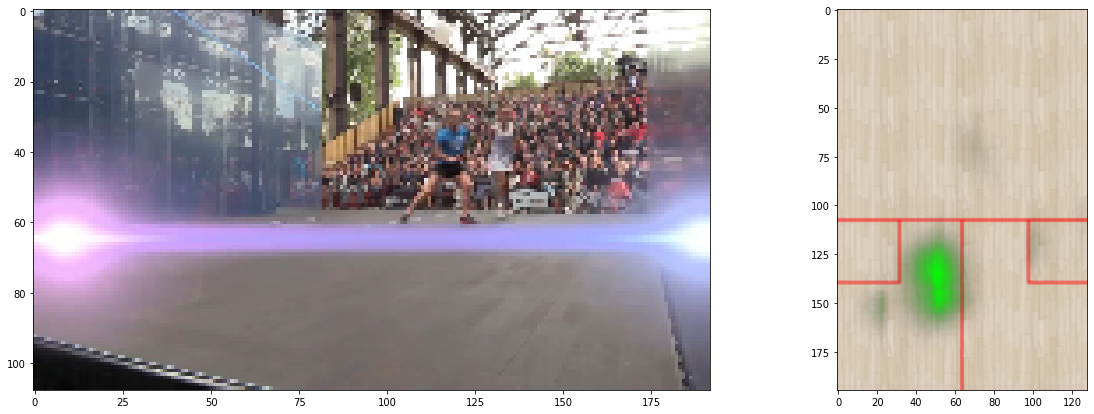

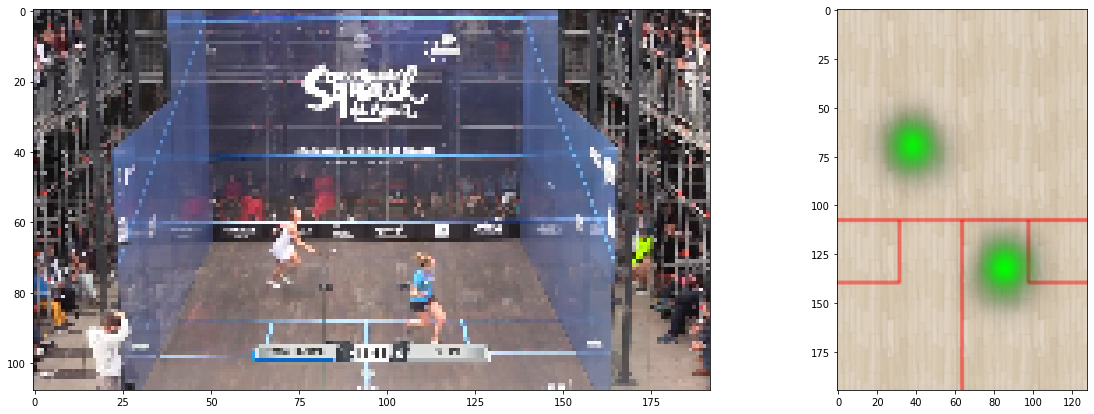

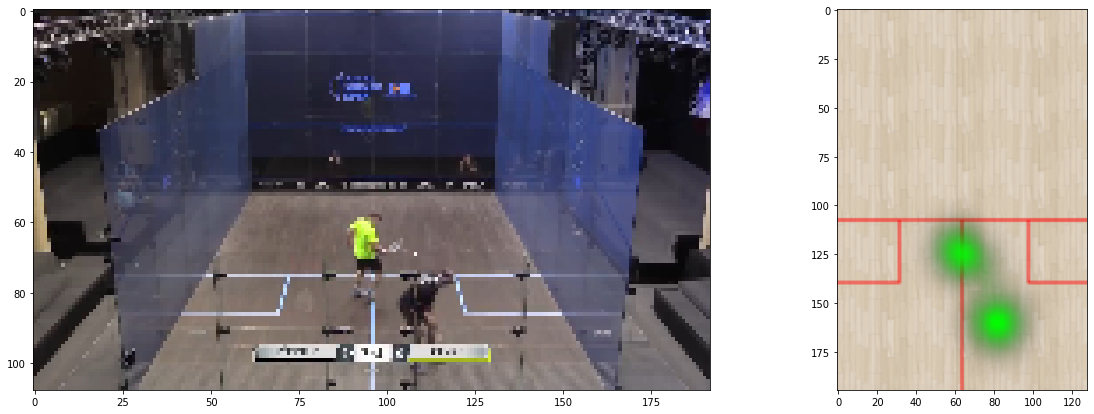

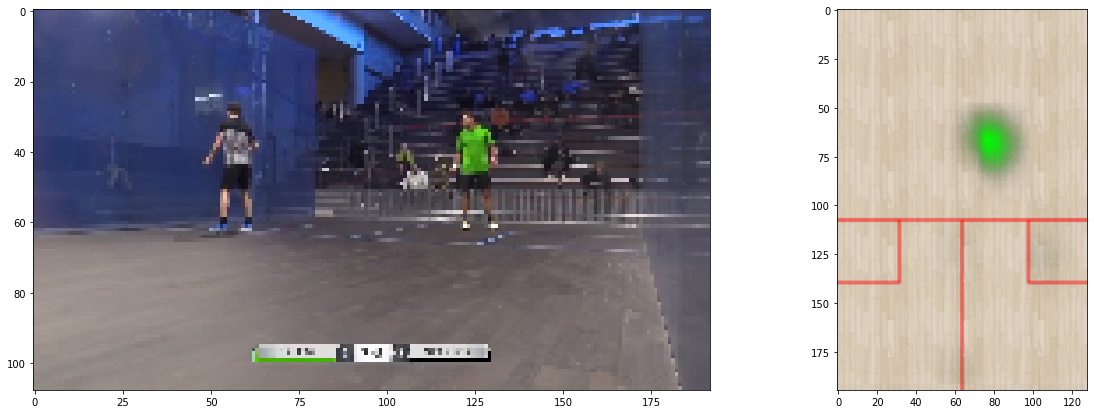

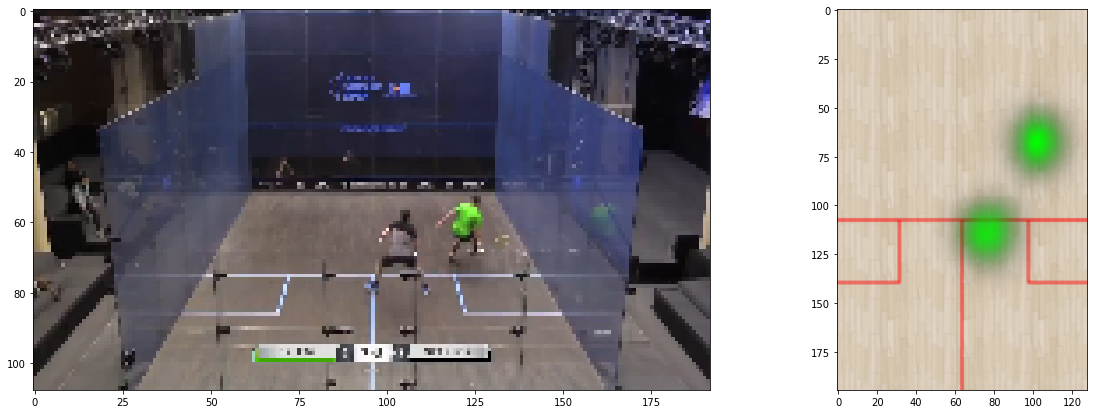

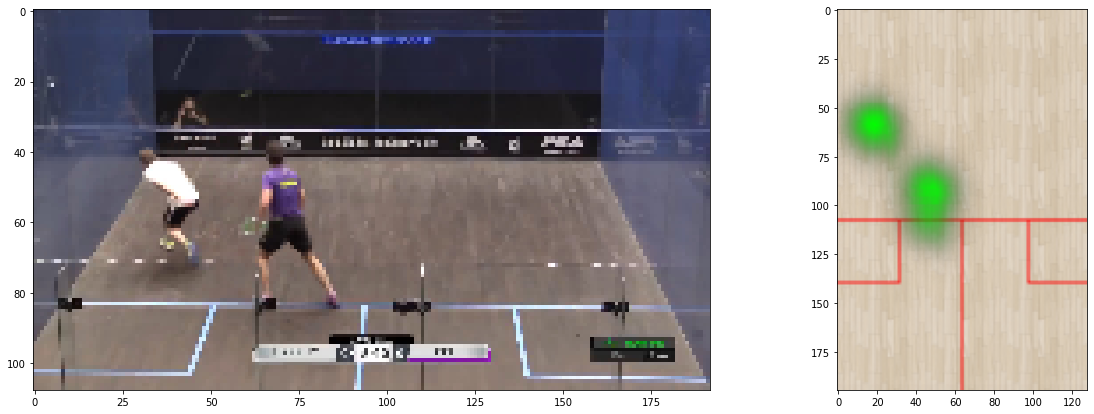

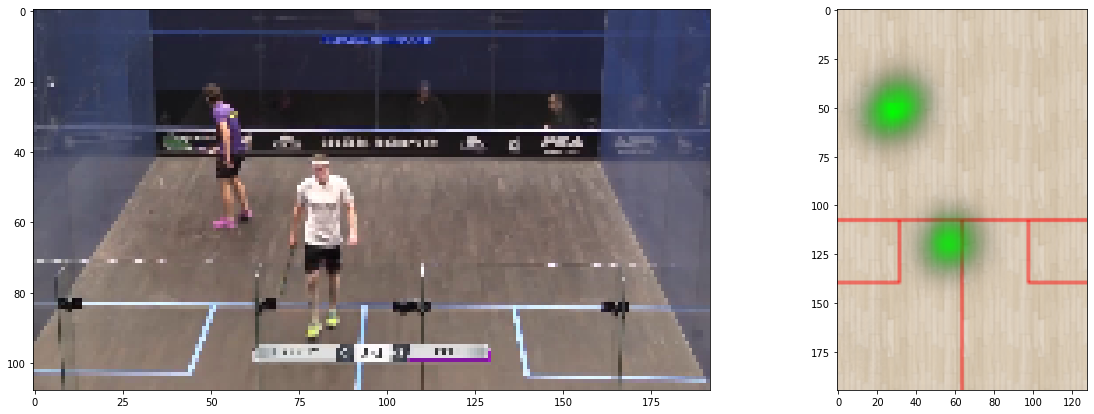

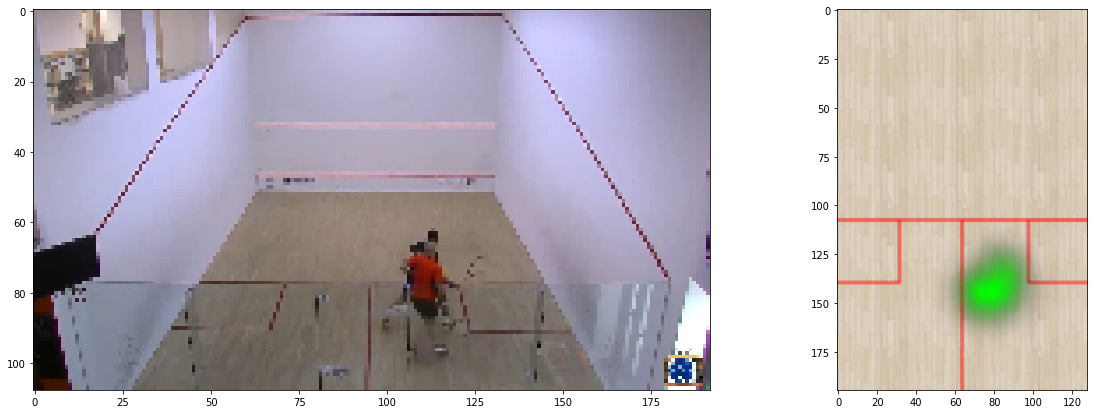

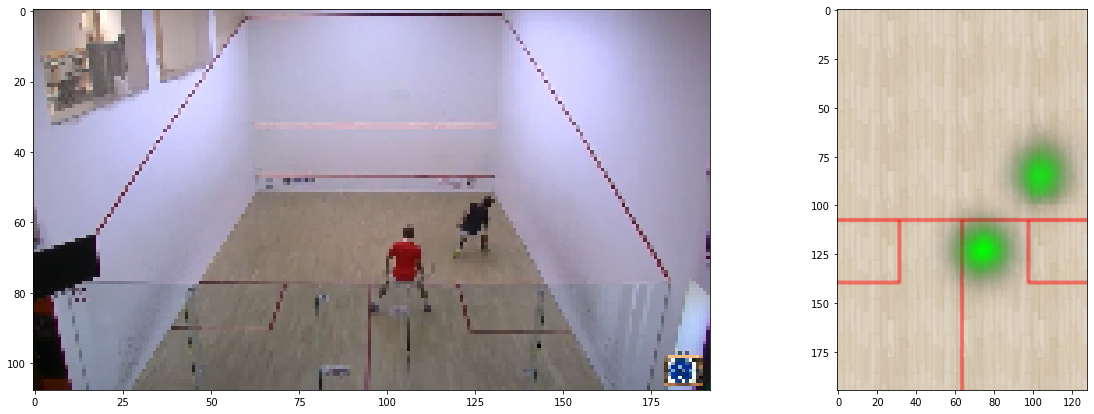

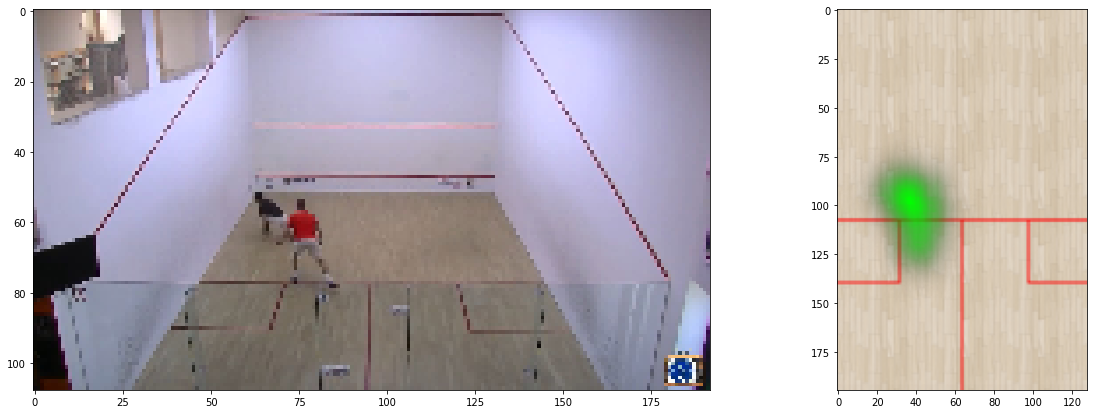

In [ ]:
FRAMES_PATH = '../drive/My Drive/colab-data'

for idx in range(1, 21):
    frame = mpimg.imread(os.path.join(FRAMES_PATH,
                                      'frame-%d.jpg' % idx))
    frame = scale(frame, MODEL_INPUT_SIZE)
    pred = model.predict(np.array([frame]))

    #pred[pred < 0.5] = 0
    plot_image(frame, heatmap=pred[0, :, :-18, :])
    #plot_image(pred[0, :, :, 0], heatmap=model_heatmaps[0])

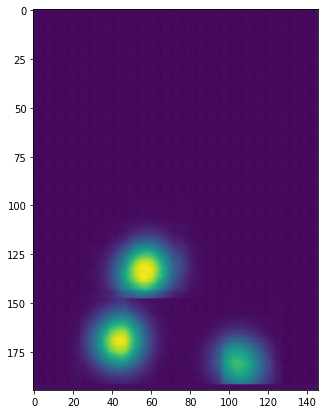

In [ ]:
FRAMES_PATH = '../drive/My Drive/colab-data'

frame = mpimg.imread(os.path.join(FRAMES_PATH, 'frame-2.jpg'))
frame = scale(frame, MODEL_INPUT_SIZE)
pred = model.predict(np.array([frame]))
for p in range(1):
    plot_image(pred[0, :, :, p])